In [917]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
import pytesseract

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from umap import UMAP 

from scipy.spatial import distance_matrix

In [918]:
raws = pytesseract.image_to_boxes(Image.open('pics/image6.png')).split('\n')[:-1]
matrix = [[int(el) for el in raw.split(' ')[1:-1]] for raw in raws]

In [919]:
dataset = (pd.DataFrame(np.array(matrix)).rename({
    0: 'x1',
    1: 'y1',
    2: 'x2',
    3: 'y2' 
    }, axis=1)
    .astype({
            'x1': int,
            'x2': int,
            'y1': int,
            'y2': int,
    }))

In [920]:
dataset['x_centroid'] = dataset['x1'] + (dataset['x2'] - dataset['x1'] /2)
dataset['y_centroid'] = dataset['y1'] + (dataset['y2'] - dataset['y1'] /2)
dataset['zero'] = 0
dataset['shape'] = abs(dataset['y2'] - dataset['y1']) * abs(dataset['x2'] - dataset['x1'])

In [921]:
x_matrix = distance_matrix(dataset[['x_centroid', 'zero']], dataset[['x_centroid', 'zero']])
x_distances = x_matrix.flatten()

y_matrix = distance_matrix(dataset[['y_centroid', 'zero']], dataset[['y_centroid', 'zero']])
y_distances = y_matrix.flatten()

x_mean_dist = np.mean(x_distances)
y_mean_dist = np.mean(y_distances)

x_std_dist = np.std(x_distances)
y_std_dist = np.std(y_distances)

In [922]:
slice_list = [i for i in range(1, 10)]

In [923]:
l2_distance = distance_matrix(dataset[['y_centroid', 'x_centroid']], dataset[['y_centroid', 'x_centroid']])
l2_matrix_n_neigh = np.sort(l2_distance, axis=0).take(slice_list, axis=0).flatten()

<AxesSubplot:ylabel='Count'>

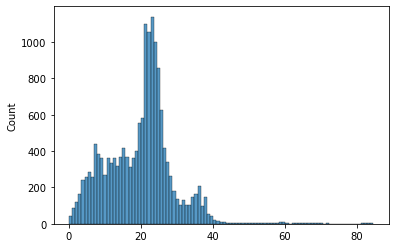

In [924]:
sns.histplot(l2_matrix_n_neigh)

In [925]:
epsilon = np.percentile(l2_matrix_n_neigh, 75)

In [926]:
epsilon

24.58149710656371

In [927]:
clustered = dataset.copy()

clustering = DBSCAN(eps=epsilon, min_samples=4).fit(dataset[['y_centroid', 'x_centroid']])
clustered['cluster'] = clustering.labels_
cluster_order = clustered.groupby('cluster').agg({'x_centroid': np.mean, 'y_centroid': np.mean}).sort_values(['y_centroid', 'x_centroid'], ascending=False).reset_index().reset_index()[['index', 'cluster']]
clustered = clustered.merge(cluster_order.rename({'index': 'cluster_order'}, axis=1), on='cluster', how='right')

22

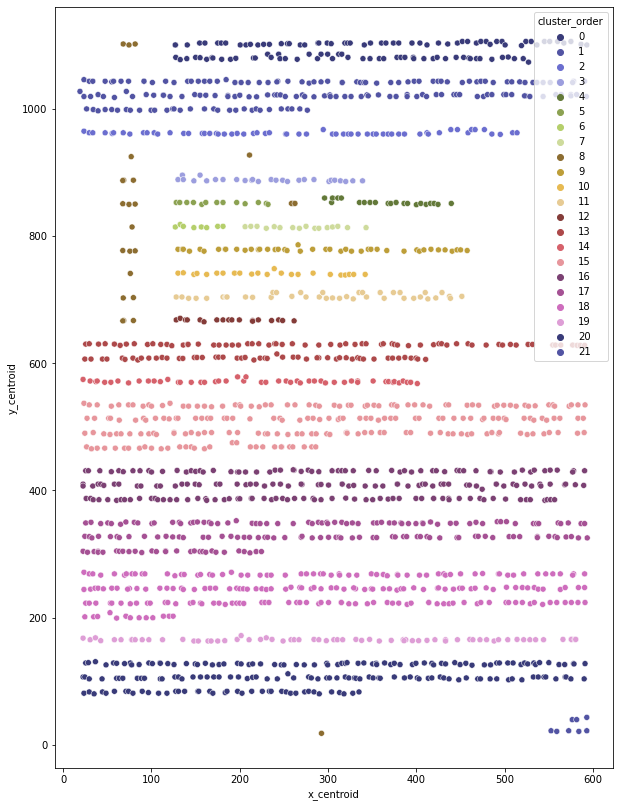

In [928]:
_, axs = plt.subplots(figsize=(10, 14))

sns.scatterplot(data=clustered, x='x_centroid', y='y_centroid', hue='cluster_order', ax=axs, palette='tab20b')

clustered.cluster_order.nunique()